In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from google.cloud import storage, bigquery
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import signal
from datetime import datetime
import gcsfs
from tempfile import NamedTemporaryFile

# Load Data

In [3]:
path = f"gs://bionics-data-store/PINT/Bladder/Processed/Compiled/acute.saline.MovingPeak_with_BP_void_compiled.csv"
raw_df = pd.read_csv(path)

Text(0.5, 1.0, 'Neural activity (Cross Correlated Peak)')

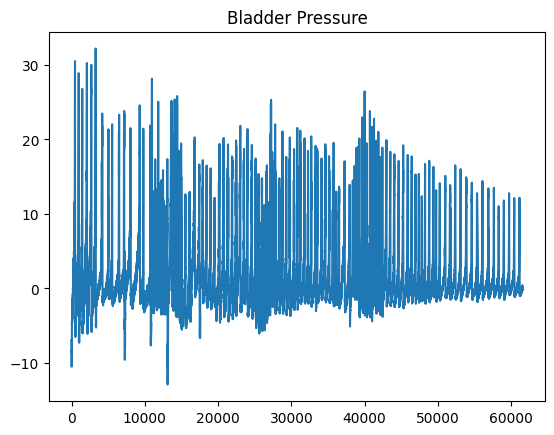

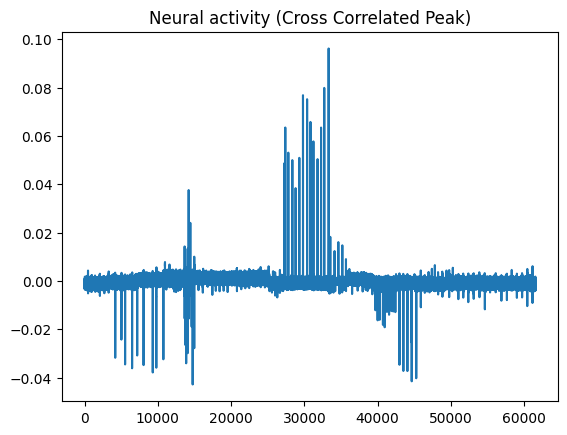

In [4]:


# Outlier removal
# Find indices where the condition is met
df = raw_df.copy()
df["bladder_pressure"] = signal.medfilt(raw_df["bladder_pressure"], 3)
df["neural_act"] = signal.medfilt(raw_df["neural_act"], 3)


# Proc data vis
plt.plot(df['bladder_pressure'])
plt.title("Bladder Pressure")
plt.figure()
plt.plot( df['neural_act'])
plt.title("Neural activity (Cross Correlated Peak)")


# Data Preparation

In [44]:
# Parameter Definitions

# Data split
split = {
    'train': 0.7, # TRAIN: 70%, TEST: 15%, VAL: 15%
    'test': 0.5,
    # val: 1-train-test
}

# Window signal splitting
input_window_size = 60;
output_window_size = 40;
target_offset_smpl = 40; # offset+output-input samples into the future

prediction_frequency = 1; # Predict every sample

# Model
model = Sequential()

# CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(50, return_sequences=True))  # Use return_sequences if adding more LSTM layers.
model.add(LSTM(50))

# Dense layer
model.add(Dense(50, activation='relu'))
model.add(Dense(output_window_size))

model.compile(optimizer='adam', loss='mse')

EPOCHS = 30
BATCH_SIZE = 32



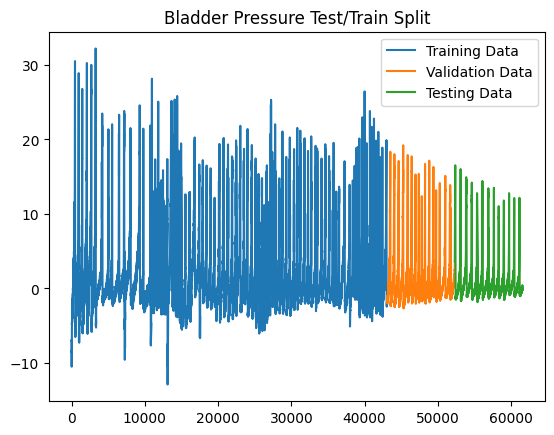

In [45]:
# Split data into train/test data
train_df, temp_df = train_test_split(df, test_size=1-split['train'], shuffle=False) 
val_df, test_df = train_test_split(temp_df, test_size=split['test'], shuffle=False) 

# Visualise
plt.plot(train_df['bladder_pressure'], label="Training Data")
plt.plot(val_df['bladder_pressure'], label="Validation Data")
plt.plot(test_df['bladder_pressure'], label="Testing Data")
plt.title("Bladder Pressure Test/Train Split")
plt.legend()

In [47]:
# Simulate live capture -> split signal into iterative windows
#
# To add: (Added) 
# - Target data offsets (i.e. how many samples into the future/past do we predict)
# - Window spacing (i.e. interwindow sample spacing -> i.e. how often are we predicting)
#
def create_windows(neural_activity, bladder_pressure, na_window_size=input_window_size, bp_window_size=output_window_size, target_offset=target_offset_smpl, window_spacing=1):
    na_windows, bp_windows = [], []
    
    max_window_size = max(na_window_size, bp_window_size)
    
    for i in range(0, len(neural_activity) - max_window_size - target_offset, window_spacing):
        na_windows.append(neural_activity[i:i+na_window_size])
        bp_windows.append(bladder_pressure[i+target_offset:i+target_offset+bp_window_size])
                
    return np.array(na_windows), np.array(bp_windows)

def batch_window_to_signal(windows_pred, windows_actual=None, window_spacing=1, extract_sample=0):
    # extract_sample: Offset from the end of the window to extract. If 0, it will extract the sample from the end of the window. The greater this is, the greater the confidence
    signal_pred = []
    signal_actual = []
    
    for window in windows_pred:
        signal_pred.extend(window[(-1-window_spacing+extract_sample):(-1+extract_sample)])
    
    if windows_actual is not None:
        for window in windows_actual:
            signal_actual.extend(window[(-1-window_spacing+extract_sample):(-1+extract_sample)])
            
    return signal_pred, signal_actual

def live_window_to_signal():
    pass

na_windows_train, bp_windows_train = create_windows(train_df['neural_act'], 
                                        train_df['bladder_pressure'],
                                                   window_spacing=prediction_frequency)


na_windows_val, bp_windows_val = create_windows(val_df['neural_act'], 
                                        val_df['bladder_pressure'],
                                               window_spacing=prediction_frequency)



# Model Training

In [64]:
# Build & Train the LSTM Model
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

model.fit(
    na_windows_train, 
    bp_windows_train, 
    validation_data=(na_windows_val, bp_windows_val), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    callbacks=[early_stop])

Epoch 1/30
1343/1343 [==============================] - 34s 25ms/step - loss: 6.5118 - val_loss: 21.0811
Epoch 2/30
1343/1343 [==============================] - 33s 25ms/step - loss: 6.0829 - val_loss: 20.1661
Epoch 3/30
1343/1343 [==============================] - 33s 25ms/step - loss: 5.6032 - val_loss: 19.6164
Epoch 4/30
1343/1343 [==============================] - 33s 24ms/step - loss: 5.3158 - val_loss: 18.8373
Epoch 5/30
1343/1343 [==============================] - 32s 24ms/step - loss: 5.0049 - val_loss: 18.9245
Epoch 6/30
1343/1343 [==============================] - 33s 25ms/step - loss: 4.6022 - val_loss: 19.7062
Epoch 7/30
1343/1343 [==============================] - 33s 25ms/step - loss: 4.3042 - val_loss: 19.4772
Epoch 8/30
1343/1343 [==============================] - 34s 25ms/step - loss: 4.1775 - val_loss: 19.4228
Epoch 9/30
1343/1343 [==============================] - 32s 24ms/step - loss: 4.0284 - val_loss: 19.4702
Epoch 10/30
1343/1343 [==============================] 

# Prediction

In [73]:
# Prediction Parameters


# Prediction

na_windows_test, bp_windows_test = create_windows(test_df['neural_act'], 
                                                test_df['bladder_pressure'],
                                                 window_spacing=prediction_frequency)

bp_pred_windows = model.predict(na_windows_test)


286/286 [==============================] - 3s 11ms/step


R2 Value: -0.6545874321789202


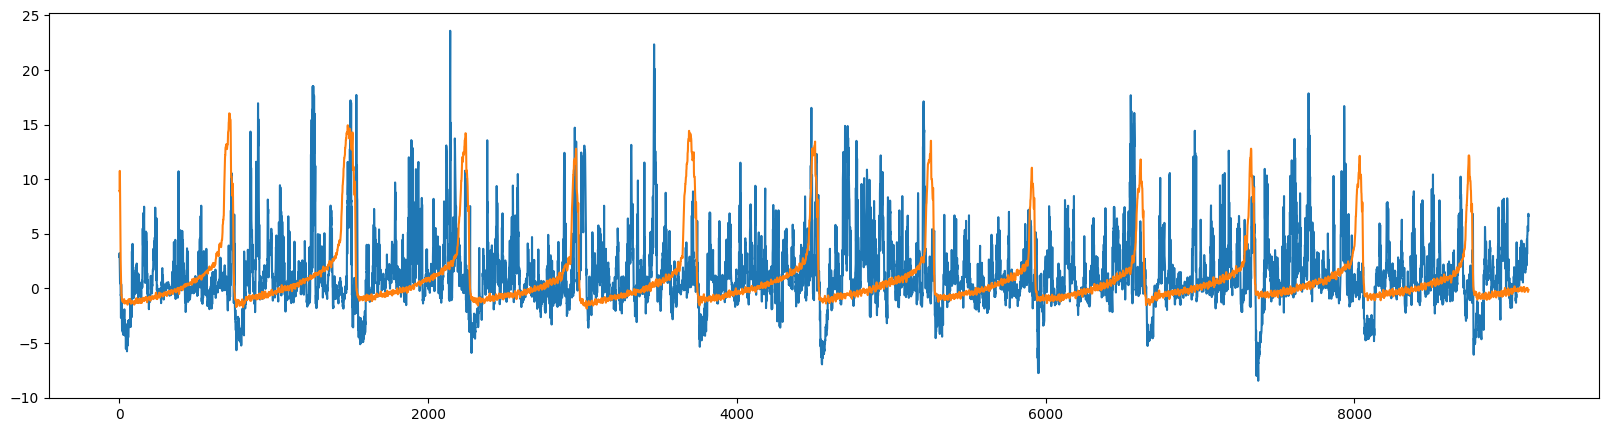

In [74]:

bp_pred_signal, bp_actual_signal = batch_window_to_signal(bp_pred_windows, bp_windows_test, window_spacing=prediction_frequency, extract_sample=0)
plt.figure(figsize=(20,5))
plt.plot(bp_pred_signal)
plt.plot(bp_actual_signal)

R2 Value: -0.6545874321789202
Actual peaks: 13
Predicted peaks: 121
Detected peaks: 4


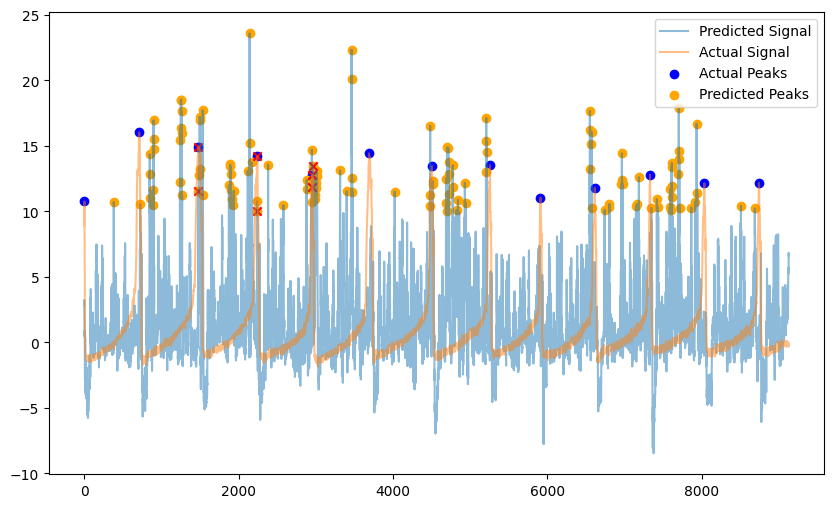

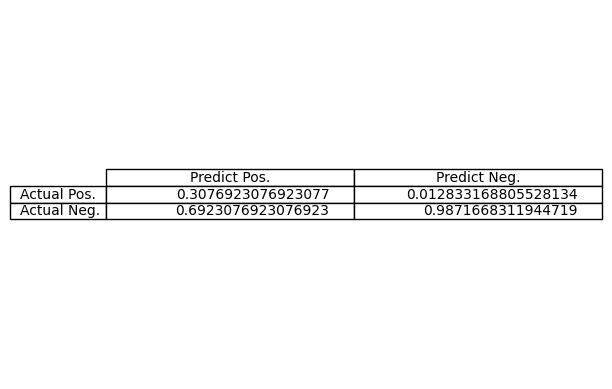

In [88]:

# Calculate r2 metric between estimated and real signal
r2 = r2_score(bp_pred_signal, bp_actual_signal)
print(f"R2 Value: {r2}")

threshold = 10
max_actual_pred_dist = 2
peak_distance_threshold = 100

# Peak detection
actual_peaks, _ = signal.find_peaks(bp_actual_signal, height=threshold, distance=peak_distance_threshold)
predicted_peaks, _ = signal.find_peaks(bp_pred_signal, height=threshold)

# Count detected peaks
detected_peaks = [(a, p) for a in actual_peaks for p in predicted_peaks if abs(a - p) <= max_actual_pred_dist]

# Results
actual_peak_count = len(actual_peaks)
predicted_peak_count = len(predicted_peaks)

print("Actual peaks:", actual_peak_count)
print("Predicted peaks:", predicted_peak_count)
print("Detected peaks:", len(detected_peaks))

# Plotting
plt.figure(figsize=(10,6))
plt.plot(bp_pred_signal, label="Predicted Signal",  alpha=0.5)
plt.plot(bp_actual_signal, label="Actual Signal", alpha=0.5)

# Plot peaks
plt.scatter(actual_peaks, [bp_actual_signal[i] for i in actual_peaks], color="blue", label="Actual Peaks")
plt.scatter(predicted_peaks, [bp_pred_signal[i] for i in predicted_peaks], color="orange", label="Predicted Peaks")
for a, p in detected_peaks:
    plt.scatter(a, bp_actual_signal[a], marker='x', color="red")
    plt.scatter(p, bp_pred_signal[p], marker='x', color="red")

    
    
plt.legend()


# Compute metrics
total_samples = len(bp_actual_signal)
TPR = len(detected_peaks) / actual_peak_count
FPR = (predicted_peak_count - len(detected_peaks)) / (total_samples - actual_peak_count)
TNR = (total_samples - predicted_peak_count - (actual_peak_count - len(detected_peaks))) / (total_samples - actual_peak_count)
FNR = 1 - TPR
# Adding the table
data = [[TPR, FPR], [FNR, TNR]]
cols = ["Predict Pos.", "Predict Neg."]
rows = ["Actual Pos.", "Actual Neg."]

# Display table
fig, ax = plt.subplots()
ax.axis("off")
ax.table(cellText=data, colLabels=cols, rowLabels=rows, loc="center")

plt.show()

In [96]:
# Save metrics to bigquery

# Initialize the BigQuery client
client = bigquery.Client()

# Set the table reference
table_ref = client.dataset('pint_metrics').table('models')


model_type = "CNN/LSTM"
time = datetime.utcnow().isoformat()
# CREATE MODEL DESCRIPTION
from io import StringIO
import sys
# Backup the standard output
original_stdout = sys.stdout
# Set the new standard output to the in-memory stream
sys.stdout = StringIO()
# Print the summary to the in-memory stream
model.summary()
# Retrieve the contents of the in-memory stream
model_description = sys.stdout.getvalue()
# Restore the standard output
sys.stdout = original_stdout
description = f"""
Parameter Definitions:

Data Split:
- Train: {split['train'] * 100}%
- Test: {split['test'] * 100}%
- Val: {100 - (split['train'] + split['test']) * 100}%

Window Signal Splitting:
- Input Window Size: {input_window_size}
- Output Window Size: {output_window_size}
- Target Offset Samples: {target_offset_smpl}
- Prediction Frequency: {prediction_frequency} (Predict every sample)

Model Info:
{model_description}

Training Parameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
"""


current_timestamp = datetime.utcnow().isoformat()


# Construct the row data
rows_to_insert = [
    {"ModelType": model_type, "Description": description, "Time": time, "R2": r2, "TPR": TPR, "FPR": FPR}
]

# Insert rows
errors = client.insert_rows_json(table_ref, rows_to_insert)

# Handle potential errors
if errors:
    print('Errors:', errors)
else:
    print('Rows inserted!')


Rows inserted!
